In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("Apple Stock Price History.csv")

# Display first rows
df.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,11/21/2025,271.49,265.95,273.33,265.67,59.03M,1.97%
1,11/20/2025,266.25,270.83,275.43,265.92,45.82M,-0.86%
2,11/19/2025,268.56,265.52,272.21,265.50,40.42M,0.42%
3,11/18/2025,267.44,269.99,270.71,265.32,45.68M,-0.01%
4,11/17/2025,267.46,268.82,270.49,265.73,45.02M,-1.82%


In [3]:
df.info()
df.describe()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1647 non-null   object 
 1   Price     1647 non-null   float64
 2   Open      1647 non-null   float64
 3   High      1647 non-null   float64
 4   Low       1647 non-null   float64
 5   Vol.      1647 non-null   object 
 6   Change %  1647 non-null   object 
dtypes: float64(4), object(3)
memory usage: 90.2+ KB


Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [4]:
# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by time
df = df.sort_values('Date').reset_index(drop=True)

# Rename columns for convenience
df = df.rename(columns={
    "Price": "Close",
    "Vol.": "Volume"
})

df.head()


,Date,Close,Open,High,Low,Volume,Change %
0,2019-05-08,50.72,50.47,51.33,50.44,105.36M,0.02%
1,2019-05-09,50.18,50.10,50.42,49.17,139.63M,-1.07%
2,2019-05-10,49.29,49.35,49.71,48.19,164.83M,-1.76%
3,2019-05-13,46.43,46.93,47.37,45.71,229.72M,-5.81%
4,2019-05-14,47.17,46.60,47.42,46.35,146.12M,1.58%


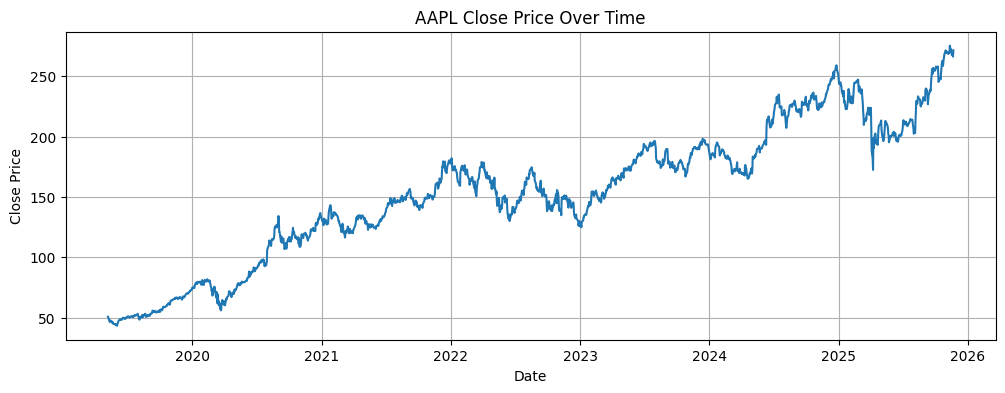

In [5]:
#APPLE CLOSE PRICE OVER TIME
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Close"])
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("AAPL Close Price Over Time")
plt.grid(True)
plt.show()


/var/folders/9n/kc857t993s5b7d0ytp2z7zzh0000gn/T/ipykernel_2141/891334839.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Daily_Return"].fillna(0, inplace=True)


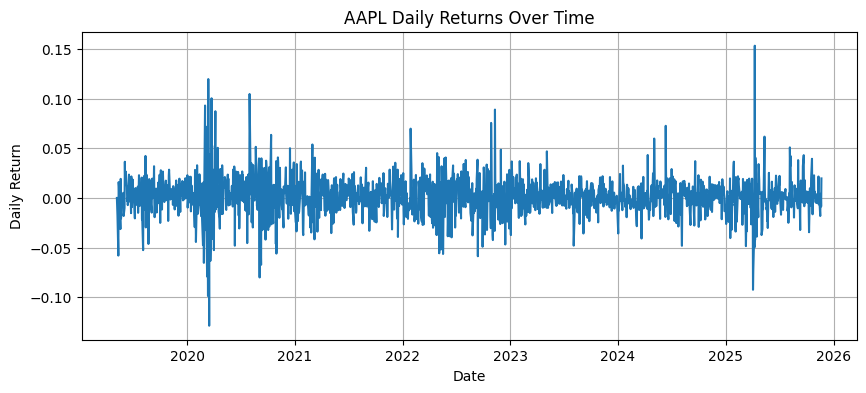

In [6]:
#DAILY RETURN ANALYSIS
df["Daily_Return"] = df["Close"].pct_change()
df["Daily_Return"].fillna(0, inplace=True)

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["Daily_Return"])
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("AAPL Daily Returns Over Time")
plt.grid(True)
plt.show()


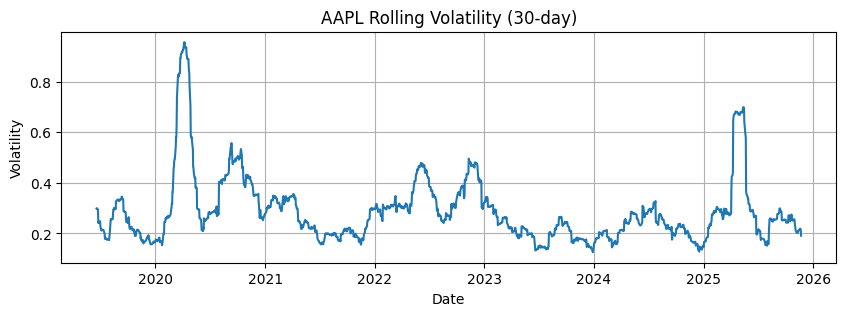

In [7]:
#ROLLING VOLATILITY
#high volatility = risky periods
#low volatility = stable periods
import numpy as np 
df["Volatility_30d"] = df["Daily_Return"].rolling(30).std() * np.sqrt(252)

plt.figure(figsize=(10,3))
plt.plot(df["Date"], df["Volatility_30d"])
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("AAPL Rolling Volatility (30-day)")
plt.grid(True)
plt.show()


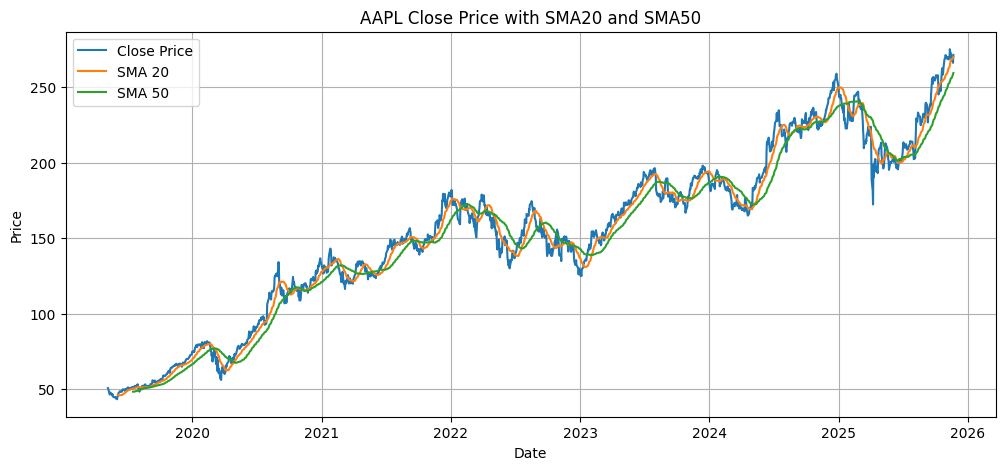

In [8]:
# Calculate Simple Moving Averages
df["SMA_20"] = df["Close"].rolling(window=20).mean()
df["SMA_50"] = df["Close"].rolling(window=50).mean()

# Plot SMA20 & SMA50
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"], label="Close Price")
plt.plot(df["Date"], df["SMA_20"], label="SMA 20")
plt.plot(df["Date"], df["SMA_50"], label="SMA 50")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("AAPL Close Price with SMA20 and SMA50")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
def fix_volume(v):
    v = str(v).replace(",", "")
    if "M" in v:
        return float(v.replace("M", "")) * 1_000_000
    if "K" in v:
        return float(v.replace("K", "")) * 1_000
    if v == "-" or v == "":
        return 0
    return float(v)

df["Volume"] = df["Volume"].apply(fix_volume)


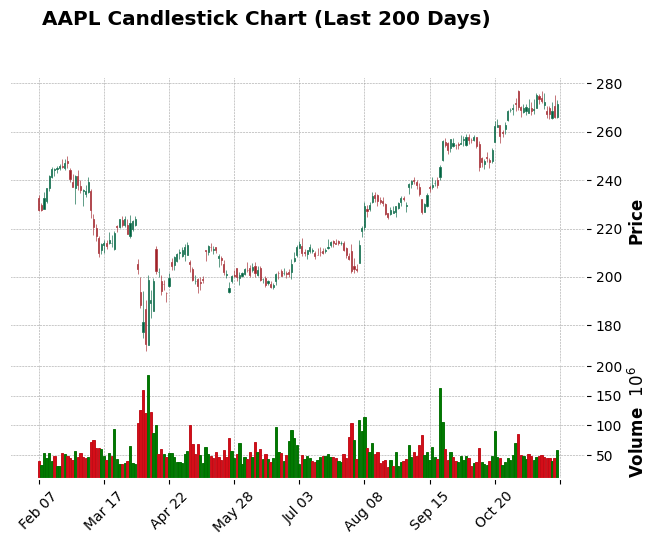

In [11]:
import mplfinance as mpf
df_candle = df.set_index("Date")[["Open", "High", "Low", "Close", "Volume"]]

mpf.plot(
    df_candle.tail(200),
    type='candle',
    style='charles',
    volume=True,
    title="AAPL Candlestick Chart (Last 200 Days)"
)


In [12]:
patterns = []

for i in range(1, len(df)):
    o, h, l, c = df.loc[i, ["Open", "High", "Low", "Close"]]
    po, pc = df.loc[i-1, ["Open", "Close"]]  # previous candle

    body = abs(c - o)
    candle_range = h - l

    # Doji
    if body <= 0.1 * candle_range:
        patterns.append("Doji")
    
    # Hammer (bullish)
    elif (c > o) and ((o - l) > 2 * body) and ((h - c) < body):
        patterns.append("Hammer")

    # Shooting Star (bearish)
    elif (o > c) and ((h - o) > 2 * body) and ((c - l) < body):
        patterns.append("Shooting Star")
    
    # Bullish Engulfing
    elif (pc < po) and (c > o) and (c > po) and (o < pc):
        patterns.append("Bullish Engulfing")

    # Bearish Engulfing
    elif (pc > po) and (c < o) and (o > pc) and (c < po):
        patterns.append("Bearish Engulfing")
    
    else:
        patterns.append("None")

df["Pattern"] = ["None"] + patterns


In [13]:
df["Buy"] = (
    ((df["Pattern"] == "Hammer") | (df["Pattern"] == "Bullish Engulfing")) |
    (df["SMA_20"] > df["SMA_50"])
)

df["Sell"] = (
    ((df["Pattern"] == "Shooting Star") | (df["Pattern"] == "Bearish Engulfing")) |
    (df["SMA_20"] < df["SMA_50"])
)


In [14]:
def is_support(df, i):
    return df['Low'][i] < df['Low'][i-1] < df['Low'][i+1]

def is_resistance(df, i):
    return df['High'][i] > df['High'][i-1] > df['High'][i+1]

levels = []

for i in range(2, len(df)-2):
    if is_support(df, i):
        levels.append((i, df['Low'][i]))
    elif is_resistance(df, i):
        levels.append((i, df['High'][i]))

support_resistance = [level[1] for level in levels]


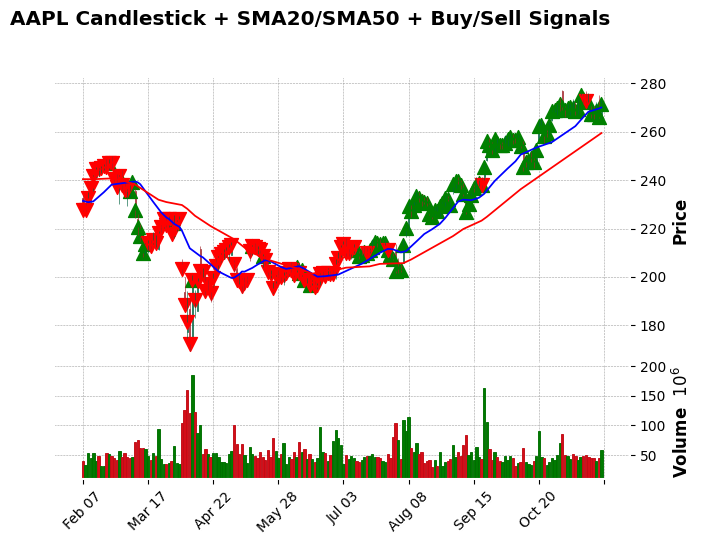

In [21]:
import mplfinance as mpf

# Use last 200 rows for everything
df_last = df.tail(200).copy()
df_last = df_last.set_index("Date")

# Addplots for SMA20 & SMA50
ap = [
    mpf.make_addplot(df_last["SMA_20"], color='blue'),
    mpf.make_addplot(df_last["SMA_50"], color='red')
]

# Buy / Sell Signals (trimmed to last 200 rows)
ap.append(
    mpf.make_addplot(
        df_last["Close"].where(df_last["Buy"]),
        type='scatter',
        marker='^',
        color='green',
        markersize=100
    )
)

ap.append(
    mpf.make_addplot(
        df_last["Close"].where(df_last["Sell"]),
        type='scatter',
        marker='v',
        color='red',
        markersize=100
    )
)

# Candlestick chart
mpf.plot(
    df_last,
    type="candle",
    style="charles",
    volume=True,
    addplot=ap,
    title="AAPL Candlestick + SMA20/SMA50 + Buy/Sell Signals"
)
